## RNN LSTM

In [1]:
# Import thư viện pytorch
# import torch
# import torch as nn
# import torchvision
# import torchvision.transforms as transforms
# import torch.nn.functional as F
# from torch import optim
# # DataLoader, split
# from torch.utils.data import DataLoader, random_split
# # Dataset
# from torchvision.datasets import MNIST

# Imports
import torch
import torch.nn.functional as F  # Parameterless functions, like (some) activation functions
import torchvision.datasets as datasets  # Standard datasets
import torchvision.transforms as transforms  # Transformations we can perform on our dataset for augmentation
from torch import optim  # For optimizers like SGD, Adam, etc.
from torch import nn  # All neural network modules
from torch.utils.data import (
    DataLoader, random_split
)  # Gives easier dataset managment by creating mini batches etc.
from tqdm import tqdm  # For a nice progress bar!

### Chuẩn bị dữ liệu

In [2]:
# train_dataset = datasets.MNIST(root='./root', train = True, download = True, transform = transforms.ToTensor())
# test_dataset = datasets.MNIST(root='./root', train = False, download = True, transform = transforms.ToTensor())

# train_loader = DataLoader(train_dataset, batch_size = 64, shuffle = True)
# test_loader = DataLoader(test_dataset, batch_size = 64, shuffle = True)

train_full_dataset = datasets.MNIST(root='dataset/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='dataset/', train=False, transform=transforms.ToTensor(), download=True)

# Chia train thành train_val_dataset: 80% và val_dataset: 20%
len_train_dataset = int(len(train_full_dataset) * 0.7)
len_val_dataset = len(train_full_dataset) - len_train_dataset

train_dataset, val_dataset = random_split(train_full_dataset, [len_train_dataset, len_val_dataset])

# Tạo DataLoader
train_full_loader = DataLoader(train_full_dataset, batch_size=64, shuffle=True)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

### Tạo mô hình RNN

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [4]:
# Parameter
input_size = 28
sequence_lenght = 28
num_layers = 2
hidden_size = 256
num_classes = 10
num_epochs = 5

class RNN(nn.Module):
  def __init__(self, input_size, hidden_size, num_layers, num_classes):
    super(RNN, self).__init__()
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first = True)
    self.fc1 = nn.Linear(hidden_size*sequence_lenght, num_classes)

  # Forward
  # x shape (batch_size, num_sequece, input_size)
  def forward(self, x):
    h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) # Shape (num_layer, batch_size, hidden_size)

    out,_ = self.rnn(x, h0) # Shape (batch_size, num_sequence, hidden_size)
    out   = out.reshape(out.shape[0], -1) # shape (batch_size, sequence_lenght * hidden_size)
    out = self.fc1(out) # shape (batch_size, input_size)
    return out


### Train mô hình

In [5]:
model = RNN(input_size, hidden_size, num_layers, num_classes).to(device = device)

In [6]:
# Binary CrossEntropy Loss
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

In [7]:
def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0

    # Set model to eval
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device).squeeze(1)
            y = y.to(device=device)

            scores = model(x)
            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)

    # Toggle model back to train
    model.train()
    return num_correct / num_samples

In [8]:
# epochs = 5
# for epoch in range(epochs):
#   for batch_idx, (data,label) in enumerate(tqdm(train_loader)):
#     data = data.to(device).squeeze(1)
#     label = label.to(device)

#     # Forward
#     out = model(data)
#     loss = criterion(out, label)

#     # Backward
#     optimizer.zero_grad()
#     loss.backward()

#     # Update
#     optimizer.step()

# Train mô hình

train_accuracies = []
val_accuracies = []
train_losses = []

for epoch in range(num_epochs):
  running_loss = 0
  for batch_id, (data, targets) in enumerate(tqdm(train_loader)):
    data = data.to(device=device).squeeze(1)
    targets = targets.to(device=device)

    # Reshape data
    # data = data.reshape(data.shape[0], -1) # Removed this line

    # Forward
    scores = model(data)
    loss = criterion(scores, targets)

    # Backward
    optimizer.zero_grad()
    loss.backward()

    # Gradient
    optimizer.step()

    running_loss += loss.item()

  train_acc = check_accuracy(train_loader, model)
  val_acc = check_accuracy(val_loader, model)  # test_loader là validation set
  avg_train_loss = running_loss / len(train_loader)
  train_accuracies.append(train_acc.item())
  val_accuracies.append(val_acc.item())
  train_losses.append(avg_train_loss)
  print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {avg_train_loss:.4f} - Train Acc: {train_acc*100:.2f}% - Val Acc: {val_acc*100:.2f}%")


100%|██████████| 657/657 [00:07<00:00, 87.99it/s]


Epoch [1/5] - Train Loss: 0.3528 - Train Acc: 94.66% - Val Acc: 94.64%


100%|██████████| 657/657 [00:07<00:00, 90.86it/s]


Epoch [2/5] - Train Loss: 0.1639 - Train Acc: 96.10% - Val Acc: 96.22%


100%|██████████| 657/657 [00:06<00:00, 94.99it/s]


Epoch [3/5] - Train Loss: 0.1276 - Train Acc: 96.55% - Val Acc: 96.36%


100%|██████████| 657/657 [00:07<00:00, 86.68it/s]


Epoch [4/5] - Train Loss: 0.1149 - Train Acc: 96.41% - Val Acc: 96.05%


100%|██████████| 657/657 [00:07<00:00, 89.26it/s]


Epoch [5/5] - Train Loss: 0.1023 - Train Acc: 97.52% - Val Acc: 97.17%


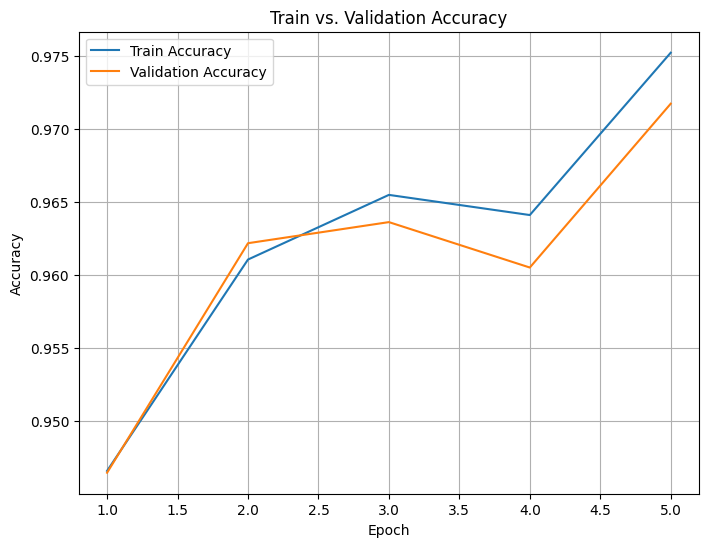

In [9]:

import matplotlib.pyplot as plt

# Vẽ biểu đồ accuracy
plt.figure(figsize=(8,6))
plt.plot(range(1, num_epochs+1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs+1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train vs. Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

### Check model

In [11]:



print(f"Accuracy FULL on training set: {check_accuracy(train_full_loader, model)*100:2f}")
print(f"Accuracy on test set: {check_accuracy(test_loader, model)*100:.2f}")

Accuracy FULL on training set: 97.416672
Accuracy on test set: 97.31


### Dự đoán 1 giá trị bất kì

torch.Size([28, 28])
Label: 7


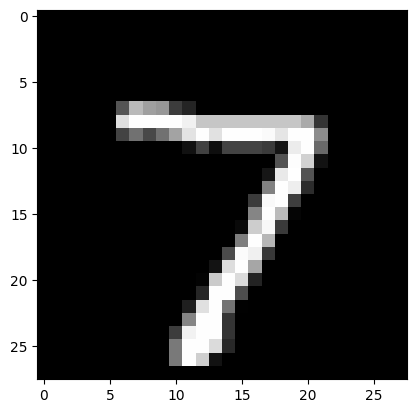

In [12]:
image = test_dataset[0][0][0]
label = test_dataset[0][1]
print(image.shape)

print(f"Label: {label}")
plt.imshow(image, cmap='gray')
plt.show()


In [13]:
# Dự đoán
predict = model(image.to(device).unsqueeze(0))

print(image.to(device).unsqueeze(0).shape)
print(predict)
print(f"Predict: {torch.argmax(predict)}")


torch.Size([1, 28, 28])
tensor([[ -9.1668,   1.2984,   1.3493,   2.1830,  -4.0237,  -2.3720, -13.1334,
          17.6814,  -2.5072,   2.9826]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
Predict: 7


## LSTM

In [14]:
class LSTM(nn.Module):
  def __init__(self, input_size, hidden_size, num_layers, num_classes):
    super(LSTM, self).__init__()
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first = True)
    self.fc = nn.Linear(hidden_size*sequence_lenght, num_classes)

  def forward(self, x):
    h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
    c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)

    # Forward
    out, _ = self.lstm(x, (h0,c0))

    out = out.reshape(out.shape[0], -1)

    out = self.fc(out)
    return out

In [15]:
model_lstm = LSTM(input_size, hidden_size, num_layers, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_lstm.parameters(), lr = 0.005)

In [16]:
for epoch in range(num_epochs):
  for batch_idx, (data, targets) in enumerate(tqdm(train_loader)):
    data = data.to(device = device).squeeze(1)
    targets = targets.to(device = device)

    # Forward
    out = model_lstm(data)
    loss = criterion(out, targets)

    # Backward
    optimizer.zero_grad()
    loss.backward()

    # Update weight
    optimizer.step()

100%|██████████| 657/657 [00:06<00:00, 95.67it/s]


In [17]:
# Check Model
print(f"Accuracy on training set: {check_accuracy(train_full_loader, model_lstm)*100:.2f}")
print(f"Accuracy on test set: {check_accuracy(test_loader, model_lstm)*100:.2f}")

Accuracy on training set: 98.89
Accuracy on test set: 98.49
